# Analysis of SOU similarities
In this problem you will use the classic *vector space model* from information retrieval to find similar SOU addresses. Your code from Assignment 1 may come in handy here.

In the vector space model, a document of words $d$ is represented by a TF-IDF vector $t(d) = (t_1(d), t_2(d), ..., t_V(d))$ of length $V$, where $V$ is the total number of words in the vocabulary. The TF-IDF weights are given by

$$
t_i(d) = n_i(d) \cdot \log \left( \frac{|D|}{\sum_{d' \in D} 1(v_i \in d')} \right)
$$

where $n_i(d)$ is the number of times term $v_i$ appears in document $d$, $\sum_{d' \in D} 1(v_i \in d')$ is the number of documents that contain term $v_i$, and $|D|$ is the total number of documents in the collection $D$. This weighting scheme favors terms that appear in few documents, but frequently in the current document. The tf-idf can be motivated with concepts in Information Theory that will be introduced later in the course.



## (a)
Compute the tf-idf vectors for each SOU address. You should lower case all of the text, and remove punctuation. 
You will have to make choices about the size of the term vocabulary to use—for example throwing out the 20 most common words, and words that appear fewer than, say, 50 times, and removing numbers.

Preprocess data: lower case all of the text, and remove punctuation

In [1]:
import string
import re
def clean_and_split(s):
    # string.punctuation is a string with all the different punctuation symbols.
    # 'tr' is an object that will assign blank space to each punctuation symbol.
    tr=str.maketrans(string.punctuation," "*len(string.punctuation))
    s=s.lower().translate(tr)
    # replace \r\n
    s = re.sub('(\r\n)+',' ',s)
    # replace whitespace substrings with one whitespace and remove leading/trailing whitespac
    s = re.sub(' +',' ',s.strip())
    return s

Load the speeches data

In [2]:
import json
speeches=[]
with open("speeches.json") as f:
    for line in f:
        speech = json.loads(line)
        speeches.append((speech['president'],speech['year'], clean_and_split(speech['text'])))

Convert the text to token counts

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sou_speeches = [speech[2] for speech in speeches]  

count_vect = CountVectorizer()
count_matrix = count_vect.fit_transform(sou_speeches)

Count the frequency of the term appearing in the corpus

In [4]:
term_frequencies = count_matrix.sum(axis=0)
terms = count_vect.get_feature_names_out()
sorted_terms = sorted(zip(terms, term_frequencies.tolist()[0]), key=lambda x: x[1], reverse=True)

print(f'Total number of terms: {len(sorted_terms)}')

Total number of terms: 25137


Exclude words that are not informative and do sanity check

In [5]:
top_20 = set(term for term, _ in sorted_terms[:20])
number = set(term for term, _ in sorted_terms if re.match(r'^[0-9]+$', term))
fewer_than_50 = set(term for term, freq in sorted_terms if freq < 50)
excluded_terms = top_20.union(number).union(fewer_than_50)

print(f'Top 20 terms: {top_20}')
print(f'Number terms: {len(number)}')
print(f'Terms with fewer than 50 occurrences: {len(fewer_than_50)}')
print(f'Excluded terms: {len(excluded_terms)}')


Top 20 terms: {'in', 'and', 'with', 'by', 'our', 'which', 'that', 'on', 'for', 'we', 'it', 'have', 'this', 'the', 'as', 'be', 'to', 'of', 'will', 'is'}
Number terms: 1378
Terms with fewer than 50 occurrences: 21880
Excluded terms: 21969


Transform tf_idf features

In [6]:
custom_vocabulary = [term for (term, _) in sorted_terms if term not in excluded_terms]
tfidf_vectorizer = TfidfVectorizer(vocabulary=custom_vocabulary, norm=None, smooth_idf=False)
tf_idf_mat = tfidf_vectorizer.fit_transform(sou_speeches)

Display the features

In [7]:
import pandas as pd

tf_idf_df = pd.DataFrame(tf_idf_mat.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tf_idf_df.head()

,has,not,been,are,their,from,government,at,all,states,...,purely,red,representations,sign,sole,started,strikes,tyranny,valley,warning
0,44.0,35.0,56.0,17.0,26.0,37.164080,21.093127,25.0,19.0,34.0,...,0.0,0.0,0.0,0.000000,2.659335,0.0,0.000000,0.0,0.000000,0.0
1,83.0,68.0,61.0,48.0,36.0,43.190688,110.487806,44.0,36.0,58.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,2.924027,0.0
2,24.0,25.0,13.0,33.0,18.0,20.088692,4.017738,14.0,25.0,11.0,...,0.0,0.0,0.0,2.924027,0.000000,0.0,3.019338,0.0,0.000000,0.0
3,49.0,65.0,23.0,45.0,25.0,19.084257,48.212861,20.0,19.0,7.0,...,0.0,0.0,0.0,0.000000,5.318670,0.0,0.000000,0.0,0.000000,0.0
4,15.0,16.0,17.0,6.0,16.0,18.079823,14.062084,18.0,8.0,15.0,...,0.0,0.0,0.0,0.000000,2.659335,0.0,0.000000,0.0,0.000000,0.0


## (b)
A similarity measure between documents is

$$
\text{sim}(d, d') = \frac{t(d) \cdot t(d')}{\|t(d)\|\|t(d')\|}
$$

the cosine of the angle between the corresponding TF-IDF vectors. In terms of this measure, find the

- 50 most similar pairs of SOUs given by different Presidents.
- 50 most similar pairs of SOUs given by the same President.
- 25 most similar pairs of Presidents, averaging the cosine similarity over all pairs of their SOUs.

When you read the above speeches, do they indeed seem similar to you? (You can read the speeches in a more reader-friendly format here: [http://www.presidency.ucsb.edu/sou.php](http://www.presidency.ucsb.edu/sou.php)) Comment on what you find, and describe what is needed to construct a better similarity measure between documents.


Compute the cosine similarity between vectors

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(tf_idf_mat)

Get the similarity for all pairs

In [9]:
import numpy as np

presidents = [speech[0] for speech in speeches]
year = [speech[1] for speech in speeches]

upper_triangle_indices = np.triu_indices_from(cosine_similarities, k=1)

similarities_with_indices = [(i, j, cosine_similarities[i, j])
                             for i, j in zip(*upper_triangle_indices)]

50 most similar pairs of SOUs given by different Presidents

In [10]:
different_presidents = [[presidents[i], year[i], presidents[j], year[j], sim] for i, j, sim in similarities_with_indices if presidents[i] != presidents[j]]
different_presidents.sort(key=lambda x: x[-1], reverse=True)
top_50_different_presidents = different_presidents[:50]
df = pd.DataFrame(top_50_different_presidents, columns=['President1', 'Year1', 'President2', 'Year2', 'Similarity'])
df

,President1,Year1,President2,Year2,Similarity
0,Martin Van Buren,1837,Andrew Jackson,1830,0.842566
1,Benjamin Harrison,1889,Grover Cleveland,1885,0.833658
2,William Howard Taft,1912,William McKinley,1899,0.829909
3,Martin Van Buren,1837,Andrew Jackson,1829,0.825330
4,Martin Van Buren,1837,Andrew Jackson,1832,0.824309
5,Martin Van Buren,1839,Andrew Jackson,1836,0.823512
6,Grover Cleveland,1886,Chester A. Arthur,1881,0.822869
7,Andrew Jackson,1830,Martin Van Buren,1838,0.821931
8,Grover Cleveland,1885,Chester A. Arthur,1881,0.815801
9,Grover Cleveland,1885,Rutherford B. Hayes,1879,0.814798


50 most similar pairs of SOUs given by the same President

In [11]:
same_presidents = [(presidents[i], year[j], year[i], sim) for i, j, sim in similarities_with_indices if presidents[i] == presidents[j]]
same_presidents.sort(key=lambda x: x[-1], reverse=True)
top_50_same_presidents = same_presidents[:50]
df = pd.DataFrame(top_50_same_presidents, columns=['President', 'Year1', 'Year2', 'Similarity'])
df

,President,Year1,Year2,Similarity
0,Barack Obama,2012,2013,0.985921
1,Theodore Roosevelt,1907,1905,0.895544
2,Theodore Roosevelt,1906,1907,0.885395
3,Theodore Roosevelt,1907,1908,0.881027
4,Theodore Roosevelt,1904,1905,0.878899
5,Theodore Roosevelt,1906,1905,0.877640
6,Theodore Roosevelt,1901,1905,0.877475
7,Grover Cleveland,1885,1886,0.874643
8,William McKinley,1899,1900,0.872673
9,Andrew Jackson,1834,1835,0.870962


25 most similar pairs of Presidents

In [12]:
president_pairs = {}
for i, j, sim in similarities_with_indices:
    if presidents[i] == presidents[j]:
        continue
    pres_pair = tuple(sorted([presidents[i], presidents[j]]))
    sim_list = president_pairs.get(pres_pair, [])
    president_pairs[pres_pair] = sim_list + [sim]

average_sims = {pair: np.mean(sims) for pair, sims in president_pairs.items()}
sorted_presidents = sorted(average_sims.items(), key=lambda x: x[1], reverse=True)
df = pd.DataFrame(sorted_presidents[:25], columns=['President Pair', 'Similarity'])
df

,President Pair,Similarity
0,"(Andrew Jackson, Martin Van Buren)",0.781933
1,"(Millard Fillmore, Zachary Taylor)",0.773981
2,"(Chester A. Arthur, Rutherford B. Hayes)",0.759963
3,"(John Tyler, Martin Van Buren)",0.759507
4,"(Andrew Jackson, Millard Fillmore)",0.758096
5,"(Martin Van Buren, Millard Fillmore)",0.754699
6,"(Benjamin Harrison, William Howard Taft)",0.753718
7,"(Benjamin Harrison, Chester A. Arthur)",0.753684
8,"(Andrew Jackson, John Tyler)",0.752178
9,"(John Tyler, Millard Fillmore)",0.749959


I didn’t detect any noticeable similarity by looking at those speeches (possibly they are all too verbose and it’s quite hard to discern similar wordings). The TF-IDF vector only measures the vocabulary use in each speech but doesn’t capture the context in which words are used (for example, although the wordings are different, different speeches can convey similar ideas.) To improve our results in finding similarity, the first thing we can do is more careful preprocessing like removing stop words. However, to construct a more sophisticated meeasure requires developing another methods like word embeddings and transformer.

## (c)
Using this vector representation, cluster the speeches using k-means. To do this you can use the sklearn implementation of k-means.
The options here limit the number of iterations of kmeans to 50, the number of clusters to 10, the clusters are initialized randomly.
Experiment with different number of clusters, and display the clusters obtained (in some manner that you choose). Comment on the clustering results, and whether or not the results are interpretable.

Routine to cluster and display the result

In [13]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

def cluster_and_display(tf_idf_mat, n_clusters=10, n_components=2):
    model = KMeans(n_clusters=n_clusters)
    sou_clust=model.fit(tf_idf_mat)
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(tf_idf_mat)

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=sou_clust.labels_)
    plt.title(f'K-means clustering with {n_clusters} clusters of State of the Union addresses')

    centroids = pca.transform(model.cluster_centers_)
    plt.scatter(centroids[:, 0], centroids[:, 1], color='r') 
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

/Users/qiuyuchen/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


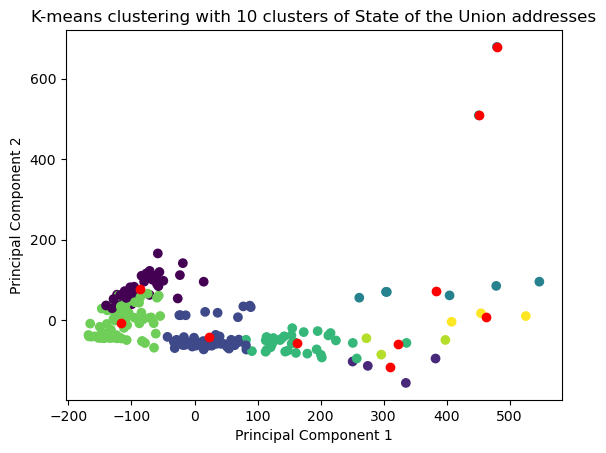

In [14]:
cluster_and_display(tf_idf_mat.toarray(), n_clusters=10, n_components=2)

/Users/qiuyuchen/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


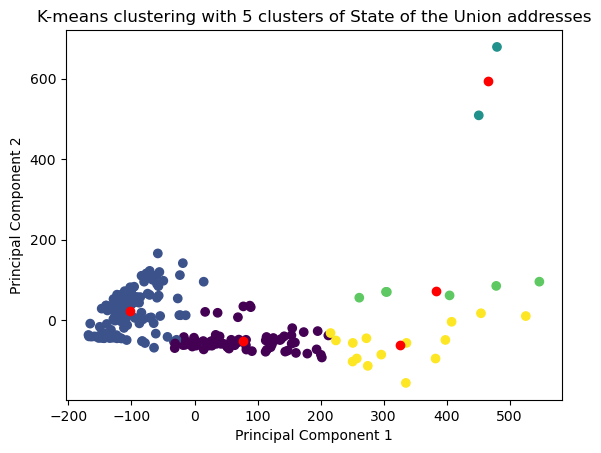

In [15]:
cluster_and_display(tf_idf_mat.toarray(), n_clusters=5, n_components=2)

/Users/qiuyuchen/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


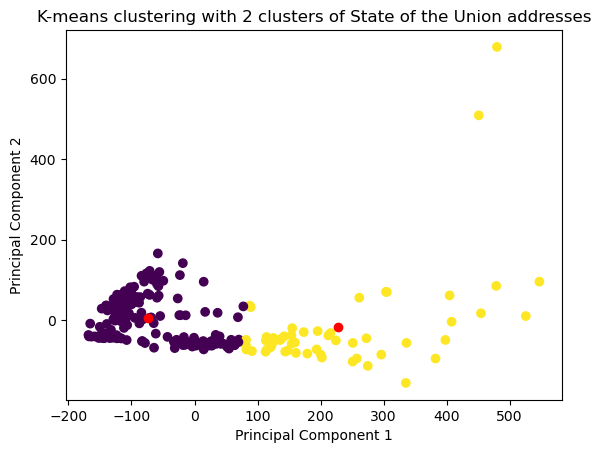

In [16]:
cluster_and_display(tf_idf_mat.toarray(), n_clusters=2, n_components=2)

The clustering is hard to interpret when I use PCA to display the results, which may due to the fact that PCA may not capture the clusters in high dimension.

## (d)
Now try performing spectral clustering using the tf-idf vectors. Compute the matrix $A$ of distances between pairs of vectors and then compute $\widetilde{W}$ as defined in class. A rule of thumb for the bandwidth $h$ is to use the mean of $A$, but you should experiment with a few values around that as well. It's a good idea to compute $A$ ahead of time, and then get $W=\exp(-A/h)$ for different values of $h$.


### i.
Plot the top 30 eigenvalues of $\widetilde{W}$, (the top eigenvalue should be 1.)

Routine to compute the eigendecomposition of $\tilde{W}$

In [17]:
from sklearn.metrics.pairwise import euclidean_distances
from numpy.linalg import eig


def eigen_W_tilde(A, h=None):
    
    if h:
        h = h
    else:
        h = np.mean(A)

    W = np.exp(-A / h)
    np.fill_diagonal(W, 0)

    D_1_2 = np.diag(np.sum(W, axis=1) ** (-0.5))

    W_tilde = D_1_2 @ W @ D_1_2

    return *eig(W_tilde), D_1_2

Show the top 30 eigenvalues

Text(0.5, 1.0, 'First 30 eigenvalues of W_tilde')

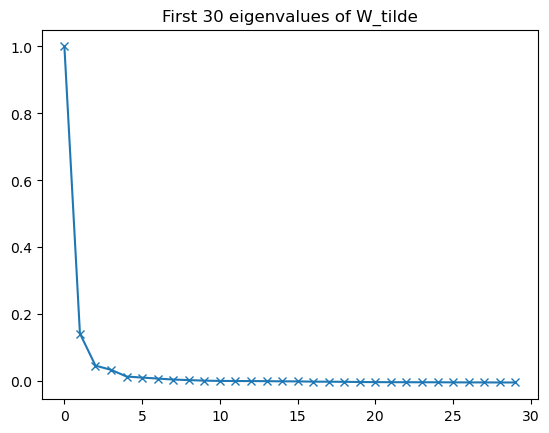

In [18]:
A = euclidean_distances(tf_idf_mat)
eigenvalues, eigenvectors, D_1_2 = eigen_W_tilde(A)
ind = np.argsort(eigenvalues)[::-1]
plt.plot(eigenvalues[ind][:30], marker='x')
plt.title('First 30 eigenvalues of W_tilde')

### ii.
Take top three eigenvectors $u_1, u_2, u_3$ multiply them on the left by $D^{-1/2}$: $v_i = D^{-1/2}u_i$, and plot the three vectors. The first should be constant corresponding to the eigenvalue 1.

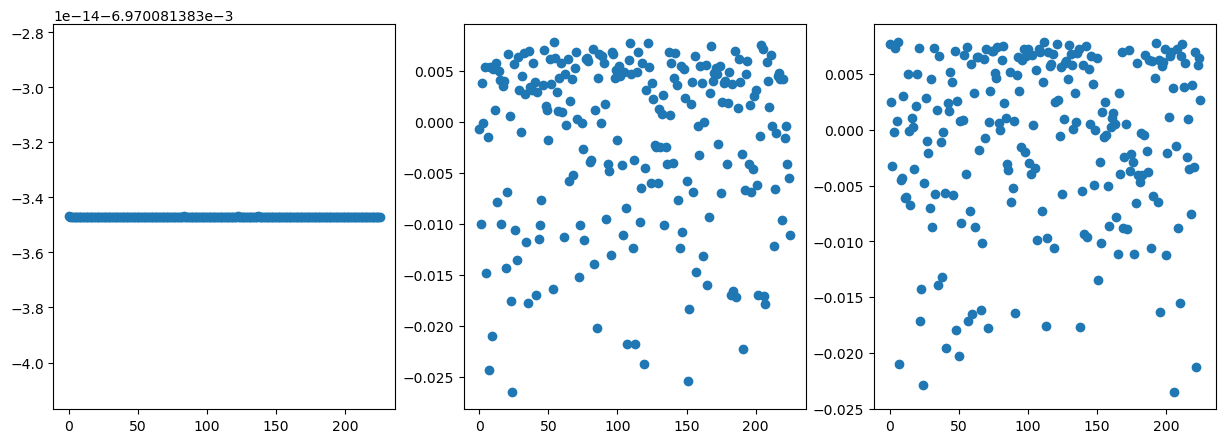

In [19]:
import matplotlib.pyplot as plt

V = D_1_2 @ eigenvectors[:, ind[:3]]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.scatter(range(len(V[:, i])), V[:, i])


### iii.
Plot a scatter plot of $v_2, v_3$, and describe what you observe. Why do you think the scatter plot looks like this?

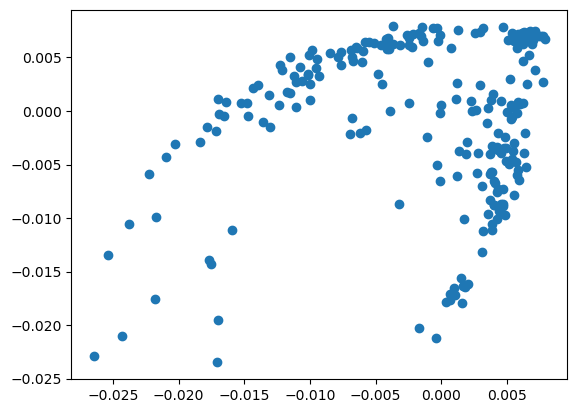

In [20]:
plt.scatter(V[:, 1], V[:, 2])

I think it's because the spectral clustering is very sensitive to the choice of h.

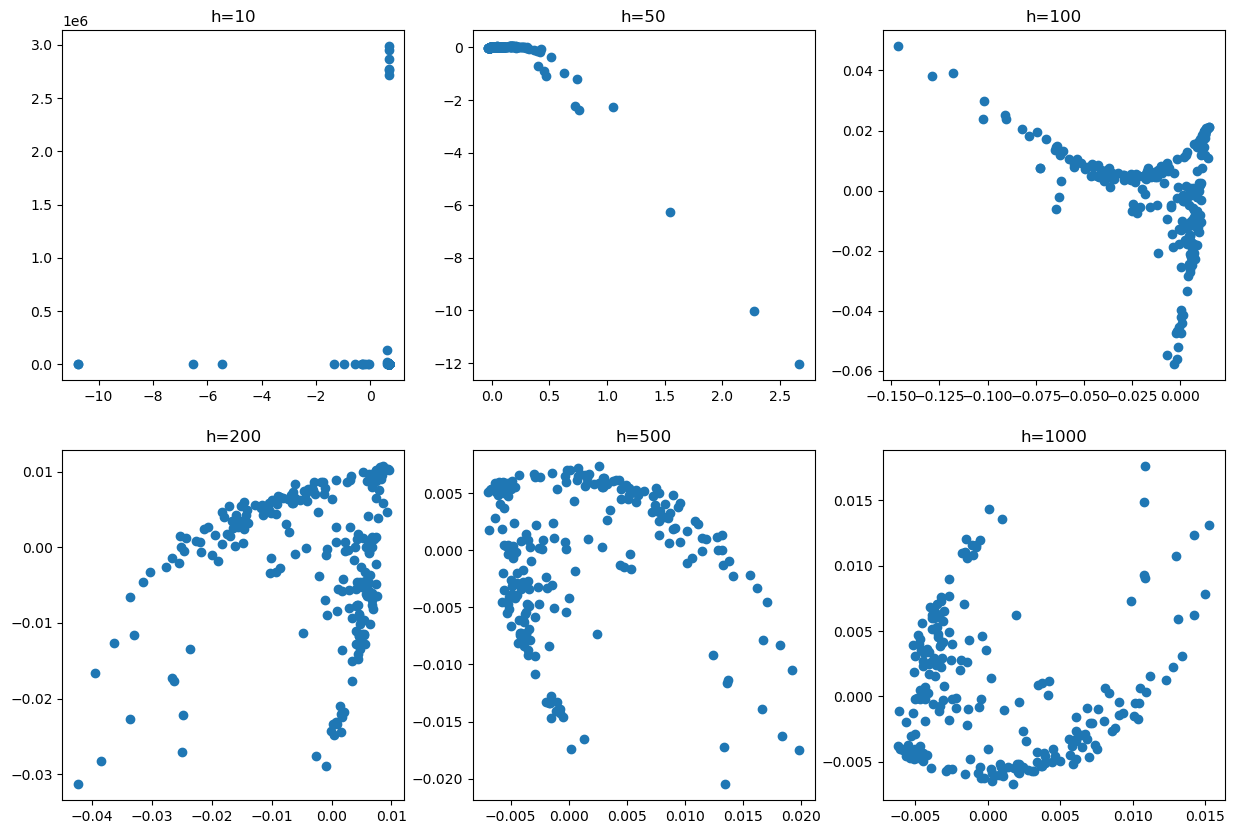

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

h_list = [10, 50, 100, 200, 500, 1000]
for i, ax in enumerate(axes.flatten()):
    eigenvalues, eigenvectors, D_1_2 = eigen_W_tilde(A, h=h_list[i])
    ind = np.argsort(eigenvalues)[::-1]
    V = D_1_2 @ eigenvectors[:, ind[:3]]
    ax.scatter(V[:, 1], V[:, 2])
    ax.set_title(f'h={h_list[i]}')

It seems that smaller h performs better on distinguishing different groups.

### iv.
Another possibility is to do the spectral clustering on the unit length vectors: $\frac{t(d)}{\|t(d)\|}$. Perform the same spectral analysis as before, and have the year of each dot printed next to it (you will need a larger figure, so use the command: `plt.figure(figsize=(10, 10))`). What do you observe in this spectral projection? Why is the analysis of the unit length vectors so different from the analysis of the original vectors?

In [22]:
from sklearn.preprocessing import Normalizer

normalizer = Normalizer(norm='l2') 
normalized_tf_idf_mat = normalizer.fit_transform(tf_idf_mat) 

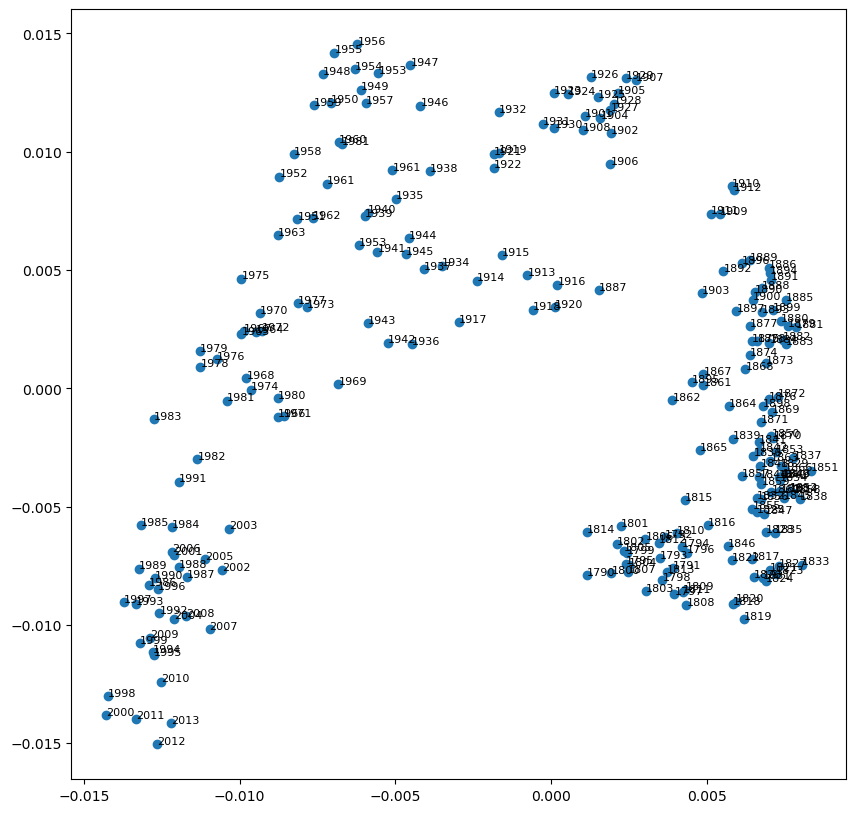

In [23]:
normalized_A = euclidean_distances(normalized_tf_idf_mat)
eigenvalues, eigenvectors, D_1_2 = eigen_W_tilde(normalized_A)
V = D_1_2 @ eigenvectors[:, ind[:3]]
plt.figure(figsize=(10, 10))
plt.scatter(V[:, 1], V[:, 2])
for i in range(V.shape[0]):
    plt.text(V[i, 1], V[i, 2], year[i], fontsize=8)

There are roughly two clusters: one before 1913 and one after 1913. Normalization removes the effect of speech length and makes the distance between different vectors comparable.

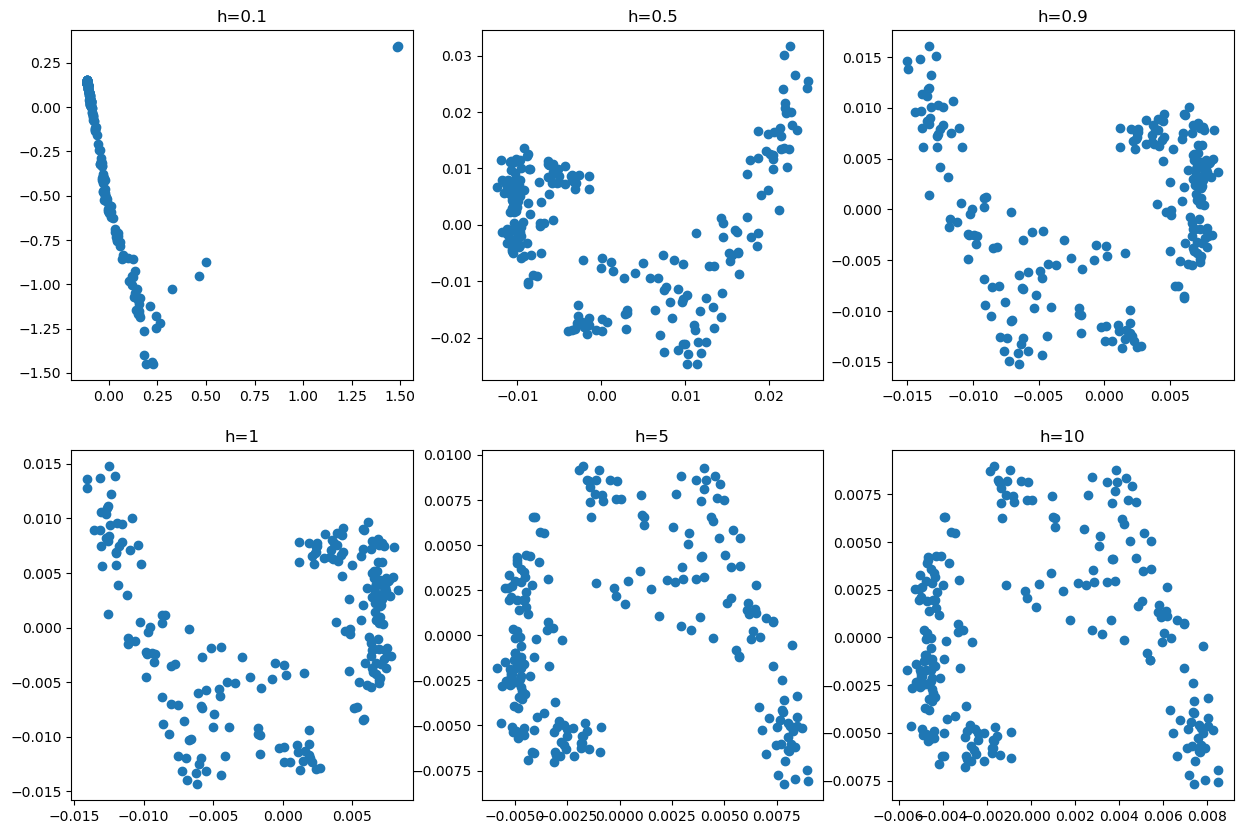

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

h_list = [0.1, 0.5, 0.9, 1, 5, 10]
for i, ax in enumerate(axes.flatten()):
    eigenvalues, eigenvectors, D_1_2 = eigen_W_tilde(normalized_A, h=h_list[i])
    ind = np.argsort(eigenvalues)[::-1]
    V = D_1_2 @ eigenvectors[:, ind[:3]]
    ax.scatter(V[:, 1], V[:, 2])
    ax.set_title(f'h={h_list[i]}')